In [1]:
import os
import numpy as np
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, BatchNormalization, ReLU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

In [2]:
# Image resizing parameters
img_rows, img_cols = 128, 128 # 224, 224
isolated_train_path = 'D:/CXR8/ChestX-ray'
isolated_test_path = 'D:/CXR8/ChestX-ray Test'

In [3]:
# Paths for training and validation data
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [4]:
# Image data parameters
img_width, img_height, channels = img_rows, img_cols, 3
batch_size = 64
num_classes = 15
num_epochs = 30

In [5]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [6]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)


In [7]:
# Training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)



Found 10500 images belonging to 15 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 2100 images belonging to 15 classes.


In [9]:
# Model parameters
IMG_SHAPE = (img_rows, img_cols, channels)

In [10]:
# Model building functions
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [11]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [12]:
def transition_layer(x, theta):
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x


In [13]:
# Model architecture
k = 12
theta = 0.5
repetitions = [6, 12, 24]
input_layer = Input(IMG_SHAPE)
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.2)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)

In [14]:
for reps in repetitions:
    x = dense_block(x, k, reps)
    x = transition_layer(x, theta)

x = GlobalAvgPool2D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 24)   3552        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64, 64, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 24)   0           ['dropout[0][0]']            

In [15]:
# Model compilation
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [16]:
# Callbacks for early stopping, saving the best model, and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [17]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
164/164 [==============================] - 74s 385ms/step - loss: 2.6197 - accuracy: 0.1298 - val_loss: 2.9403 - val_accuracy: 0.0771 - lr: 0.0010
Epoch 2/30
164/164 [==============================] - 60s 364ms/step - loss: 2.5268 - accuracy: 0.1627 - val_loss: 2.8911 - val_accuracy: 0.1060 - lr: 0.0010
Epoch 3/30
164/164 [==============================] - 60s 364ms/step - loss: 2.4978 - accuracy: 0.1712 - val_loss: 2.8199 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 4/30
164/164 [==============================] - 60s 367ms/step - loss: 2.4751 - accuracy: 0.1832 - val_loss: 2.7508 - val_accuracy: 0.0918 - lr: 0.0010
Epoch 5/30
164/164 [==============================] - 59s 360ms/step - loss: 2.4597 - accuracy: 0.1805 - val_loss: 3.5128 - val_accuracy: 0.0918 - lr: 0.0010
Epoch 6/30
164/164 [==============================] - 59s 359ms/step - loss: 2.4374 - accuracy: 0.1889 - val_loss: 2.8488 - val_accuracy: 0.0947 - lr: 0.0010
Epoch 7/30
164/164 [==============================] 

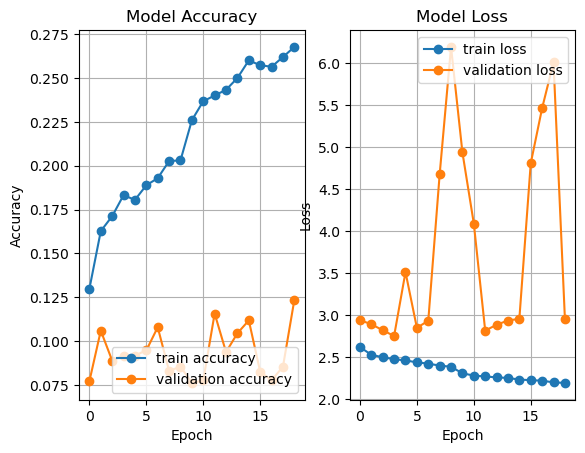

In [18]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

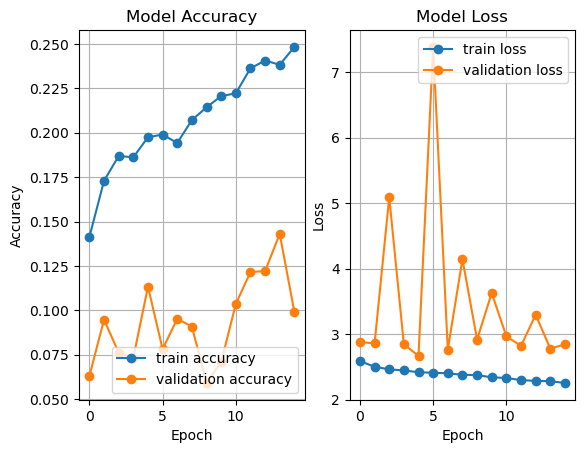

In [ ]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [44]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
Y_pred = model.predict(validation_generator, num_validation_samples// batch_size)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76' ]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

79/79 [==============================] - 17s 212ms/step
(1580, 15)
              precision    recall  f1-score   support

          62      0.180     0.162     0.171       111
          63      0.333     0.342     0.338       111
          64      0.255     0.108     0.152       111
          65      0.573     0.532     0.551       111
          66      0.230     0.153     0.184       111
          67      0.136     0.216     0.167       111
          68      0.027     0.259     0.049        27
          69      0.807     0.645     0.717       110
          70      0.091     0.027     0.042       111
          71      0.141     0.126     0.133       111
          72      0.183     0.117     0.143       111
          73      0.206     0.261     0.230       111
          74      0.095     0.036     0.052       111
          75      0.483     0.631     0.547       111
          76      0.149     0.117     0.131       111

    accuracy                          0.248      1580
   macro avg 